<a href="https://colab.research.google.com/github/kaalachor/Whatsapp_Wordcloud/blob/master/Whatsapp_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## Text Processing functions

In [3]:
def startsWithDate(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [5]:
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

## Enter your file path here

In [6]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/text.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

## Pandas Dataframe

In [7]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

,Date,Time,Author,Message
0,15/07/2018,20:13,Danish,Lol
1,16/07/2018,15:06,Atharva,Mast
2,16/07/2018,15:06,Atharva,Base model?
3,16/07/2018,15:06,Saumya Doogar,Idea pad
4,16/07/2018,18:29,Saumya Doogar,Poochke batana


## Visualizations

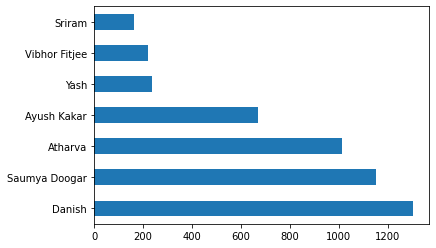

In [8]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_10_author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

          Date   Time         Author          Message
18  16/07/2018  21:18  Saumya Doogar  <Media omitted>
30  16/07/2018  22:10         Danish  <Media omitted>
35  16/07/2018  22:36        Atharva  <Media omitted>
36  16/07/2018  22:36        Atharva  <Media omitted>
51  17/07/2018  17:58  Saumya Doogar  <Media omitted>


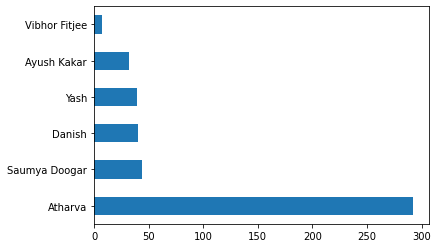

In [9]:
media_messages_df = df[df['Message'] == '<Media omitted>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

In [10]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
161,22/07/2018,10:52,None,Self Bsnl added Yash
1503,22/08/2018,14:23,None,Ayush Kakar left
2460,16/02/2019,20:43,None,Self Bsnl added Ayush Kakar
2564,17/02/2019,13:12,None,Ayush Kakar changed this group's icon
2565,17/02/2019,13:13,None,"Ayush Kakar changed the subject from ""Vele log..."


In [11]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()
messages_df.describe

<bound method NDFrame.describe of             Date   Time         Author                                 Message
0     15/07/2018  20:13         Danish                                     Lol
1     16/07/2018  15:06        Atharva                                    Mast
2     16/07/2018  15:06        Atharva                             Base model?
3     16/07/2018  15:06  Saumya Doogar                                Idea pad
4     16/07/2018  18:29  Saumya Doogar                          Poochke batana
...          ...    ...            ...                                     ...
4782  05/08/2020  15:16         Danish                      बधाई हो श्रीराम जी
4786  28/08/2020  19:55    Ayush Kakar                                Arre wah
4787  28/08/2020  19:55  Saumya Doogar                                     Gay
4789  28/08/2020  19:56    Ayush Kakar  Ye bilkool atharv jesa he lag raha hai
4791  28/08/2020  19:58  Saumya Doogar                                 Boobies

[4310 rows x 4 co

In [12]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [13]:
discrete_columns = ['Date', 'Time', 'Author', 'Message']
messages_df[discrete_columns].describe()

continuous_columns = ['Letter_Count', 'Word_Count']
messages_df[continuous_columns].describe()

,Letter_Count,Word_Count
count,4310.000000,4310.000000
mean,21.950812,3.991647
std,122.935783,6.469087
min,1.000000,1.000000
25%,6.000000,1.000000
50%,14.000000,3.000000
75%,26.000000,5.000000
max,7776.000000,234.000000


In [14]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(94608, 17204)

Text(0, 0.5, 'Authors')

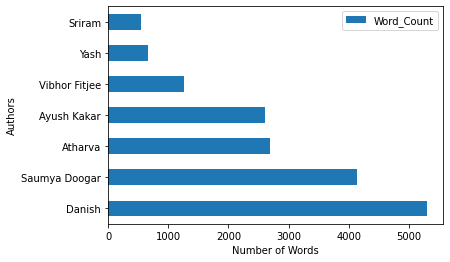

In [15]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

Text(0, 0.5, 'Frequency')

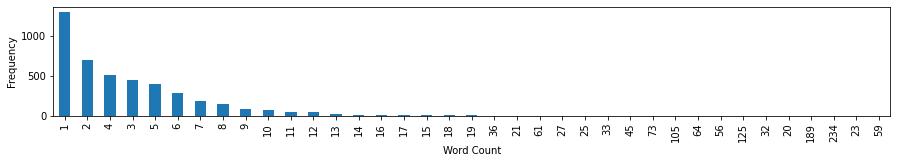

In [16]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Date')

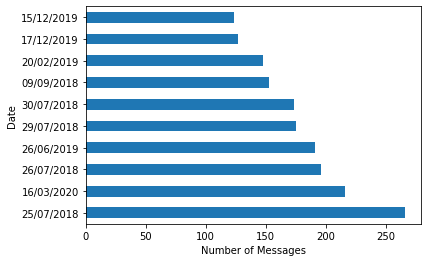

In [17]:
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0, 0.5, 'Time')

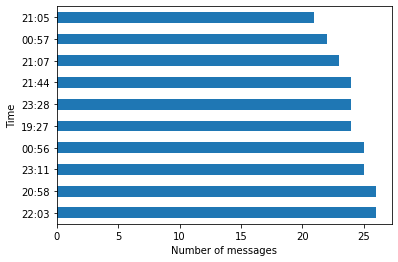

In [18]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

In [19]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")

Text(0, 0.5, 'Hour of Day')

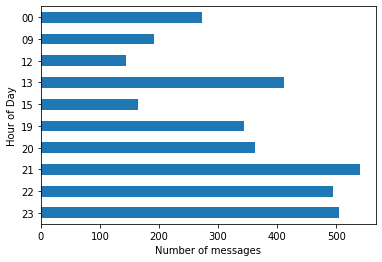

In [20]:
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [21]:
messages_df['Message'].describe

<bound method NDFrame.describe of 0                                          Lol
1                                         Mast
2                                  Base model?
3                                     Idea pad
4                               Poochke batana
                         ...                  
4782                        बधाई हो श्रीराम जी
4786                                  Arre wah
4787                                       Gay
4789    Ye bilkool atharv jesa he lag raha hai
4791                                   Boobies
Name: Message, Length: 4310, dtype: object>

## Making a wordcloud using Wordcloud library , pandas dataframe and matplotlib.

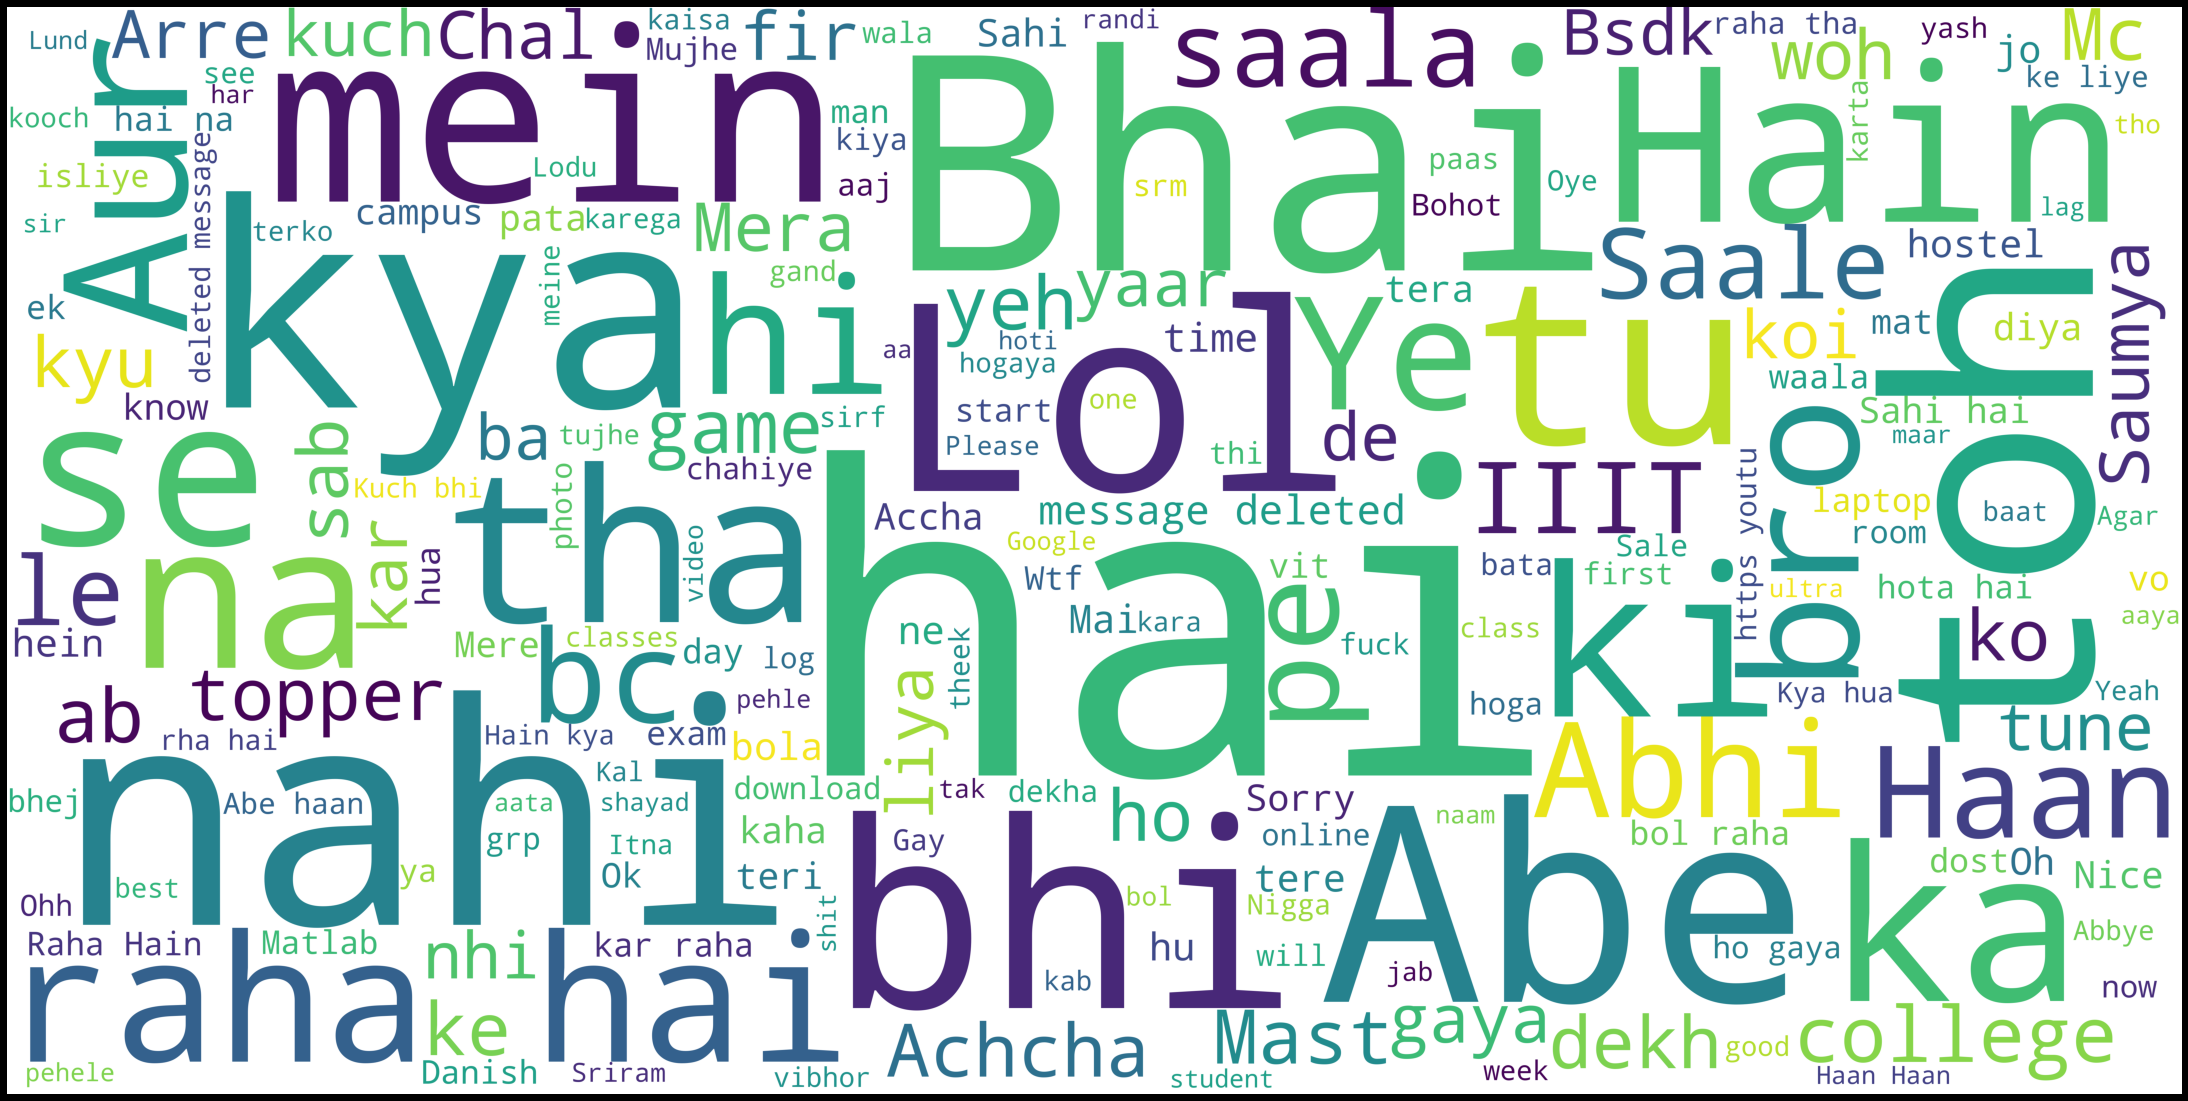

In [22]:
from wordcloud import WordCloud 

wordcloud = WordCloud(width = 8000, height = 4000, 
            background_color ='white', 
            min_font_size = 20).generate(' '.join(messages_df['Message']))
plt.figure(figsize=(40,20),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()